In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        h = self.activation(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [3]:
# Define Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        h = self.activation(self.fc1(x))
        x_hat = self.fc2(h)
        return x_hat

In [4]:
# Reparameterization Trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [5]:
import json
import numpy as np
total_obj=1136
paragraphs = []
with open('../../ics_cwe/id_to_desc.json') as fp:
    id_to_desc = json.load(fp)
for i in range(total_obj):
    paragraphs.append(id_to_desc[str(i)])
graph_embeddings = np.load("../../ics_cwe/{}/sample_{}/{}/text_hop_dual_gm_1.0.npy".format("GCN",4,"pt_Gpt2"))
text_embeddings = np.load("../../ics_cwe/Text_Hop/{}/data/all_embeddings.npy".format("pt_Gpt2"))

In [6]:
graph_embeddings.shape

(1136, 128)

In [10]:
# Hyperparameters
text_embedding_dim = text_embeddings.shape[1]  # Example text embedding dimension
graph_embedding_dim = graph_embeddings.shape[1]  # Desired graph embedding dimension
hidden_dim = 512
latent_dim = 128
lr = 0.001
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

In [14]:
text_embeddings_tensor = torch.tensor(text_embeddings, dtype=torch.float32).to(device)
graph_embeddings_tensor = torch.tensor(graph_embeddings, dtype=torch.float32).to(device)

In [15]:
# Initialize Encoder and Decoder
encoder = Encoder(text_embedding_dim, hidden_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, hidden_dim, graph_embedding_dim).to(device)

In [16]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)



In [18]:
# Training the cGAN
epochs = 10000
# Training loop
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    mu, logvar = encoder(text_embeddings_tensor)
    z = reparameterize(mu, logvar)
    predicted_graph_embeddings = decoder(z)
    
    # Compute loss
    loss = loss_function(predicted_graph_embeddings, graph_embeddings_tensor, mu, logvar)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.3955
Epoch [200/10000], Loss: 0.3410
Epoch [300/10000], Loss: 0.3148
Epoch [400/10000], Loss: 0.3097
Epoch [500/10000], Loss: 0.3078
Epoch [600/10000], Loss: 0.3032
Epoch [700/10000], Loss: 0.3032
Epoch [800/10000], Loss: 0.3023
Epoch [900/10000], Loss: 0.3020
Epoch [1000/10000], Loss: 0.3016
Epoch [1100/10000], Loss: 0.3011
Epoch [1200/10000], Loss: 0.3037
Epoch [1300/10000], Loss: 0.2991
Epoch [1400/10000], Loss: 0.3004
Epoch [1500/10000], Loss: 0.2995
Epoch [1600/10000], Loss: 0.3033
Epoch [1700/10000], Loss: 0.2985
Epoch [1800/10000], Loss: 0.2993
Epoch [1900/10000], Loss: 0.2999
Epoch [2000/10000], Loss: 0.2990
Epoch [2100/10000], Loss: 0.2990
Epoch [2200/10000], Loss: 0.2978
Epoch [2300/10000], Loss: 0.2985
Epoch [2400/10000], Loss: 0.2982
Epoch [2500/10000], Loss: 0.2985
Epoch [2600/10000], Loss: 0.2988
Epoch [2700/10000], Loss: 0.2984
Epoch [2800/10000], Loss: 0.2985
Epoch [2900/10000], Loss: 0.2980
Epoch [3000/10000], Loss: 0.2990
Epoch [3100/10000],

In [19]:
# Optionally, save the model
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, 'data/vae_model.pth')

In [82]:
# # Define the noise parameters
# noise_stddev = 0.3  # Standard deviation of the noise
# noise = np.random.normal(loc=0.0, scale=noise_stddev, size=text_embeddings.shape)

# # Add the noise to the original embeddings
# noisy_embeddings = text_embeddings + noise
# with open("data/noisy_text_embeddings.npy", 'wb') as f:
#     np.save(f,noisy_embeddings)

In [20]:
with open("data/noisy_text_embeddings.npy", 'rb') as f:
    noisy_embeddings = np.load(f)

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def get_sim(gen_emb, org_emb):
    # Compute the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(gen_emb, org_emb)
    diagonal_values = np.diagonal(cosine_sim_matrix)
    # print(cosine_sim_matrix.shape)  # Should print (203, 933)
    return diagonal_values

In [22]:
import numpy as np
import random
from matplotlib import pyplot as plt
def plot(sim_vec, title):
    plt.figure(figsize=(5, 5))
    plt.hist(sim_vec, bins=np.arange(0, 1.1, 0.05), edgecolor='black')  
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.savefig(title+".png", dpi=300, bbox_inches='tight')
    # Show plot
    plt.show()

In [23]:
sim_vec2 = get_sim(noisy_embeddings, text_embeddings)
sim_vec2

array([0.82619745, 0.79746806, 0.83329961, ..., 0.82669496, 0.83534306,
       0.84865667])

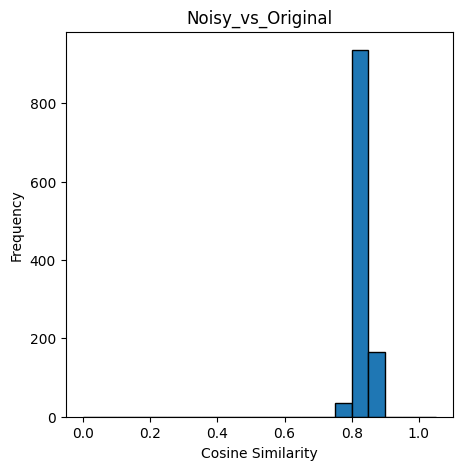

In [101]:
plot(sim_vec2, "Noisy_vs_Original")

In [26]:
# Function to generate graph embeddings for new text embeddings
def generate_graph_embeddings(new_text_embeddings):
    new_text_embeddings = torch.tensor(new_text_embeddings, dtype=torch.float32).to(device)
    # Load the model state
    checkpoint = torch.load('data/vae_model.pth', map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    loss = checkpoint['loss']
    
    # Ensure the models are in evaluation mode
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        mu, logvar = encoder(new_text_embeddings)
        z = reparameterize(mu, logvar)
        generated_graph_embeddings = decoder(z)
    return generated_graph_embeddings.cpu().detach().numpy()

In [27]:
graph1 = generate_graph_embeddings(text_embeddings)

In [29]:
graph2 = generate_graph_embeddings(noisy_embeddings)

In [105]:
# with open("../../ics_cwe/Text_Hop/{}/data/Encoder_Decoder_generated.npy".format("pt_Gpt2"), 'wb') as f:
#     np.save(f,generated_graph_embeddings)

In [30]:
sim_vec1 = get_sim(graph1, graph_embeddings)

In [31]:
sim_vec2 = get_sim(graph2, graph_embeddings)

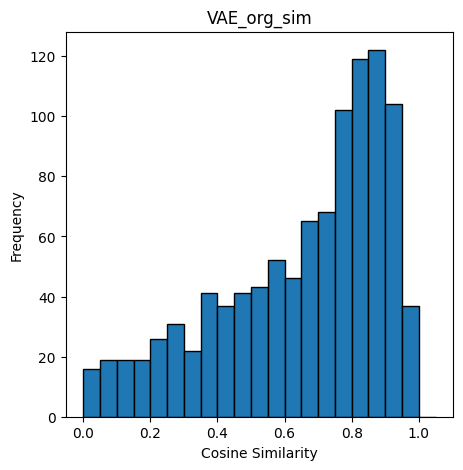

In [32]:
plot(sim_vec1, "VAE_org_sim")

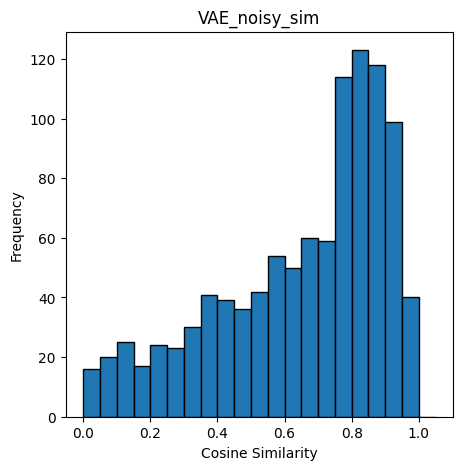

In [33]:
plot(sim_vec2, "VAE_noisy_sim")